In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import dizx
from dizx import Edge
from dizx import clifford_simplifier as simp
Phase = dizx.CliffordPhase
d = 3
Z = dizx.VertexType.Z
X = dizx.VertexType.X

In [ ]:
from sympy import symbols
a = symbols("a")
ainv = symbols("ainv")
b = symbols("b")
binv = symbols("binv")
Hadj = dizx.gates.HAD(0,adjoint=True)
H = dizx.gates.HAD(0)
S = dizx.gates.S(0)

lhs = dizx.Circuit(qudit_amount=1, dim=3)
lhs += H**-1 + S**-a + H**-1 + S**-ainv + H**-1 + S**(-a*(b+1)) + H


In [3]:
#R28 from supplement
from dizx.circuit.gates import CZ, CX, HAD, S, Z, X

lhs = dizx.Circuit(qudit_amount=2, dim=3)
lhs += CZ(0,1)
lhs += HAD(0)**2 + HAD(1)
lhs += CZ(0,1)
lhs += CX(1,0)
rhs = dizx.Circuit(qudit_amount=2, dim=3)
rhs += HAD(1)
rhs += CZ(0,1) + CX(1,0)
rhs += S(1) + HAD(1)**2 + S(1)
rhs += CX(0,1)**2
rhs += S(1) + Z(1)


In [4]:
c = lhs + rhs.adjoint()
c

Circuit[3](2 qudits, 0 dits, [CZ(0,1), HAD^2(0), HAD(1), CZ(0,1), CX(1,0), Z^-1(1), S^-1(1), CX^-2(0,1), S^-1(1), HAD^-2(1), S^-1(1), CX^-1(1,0), CZ^-1(0,1), HAD^-1(1)] gates)

In [5]:
print(c.to_qasm())

OPENQASM D.0;
include "qelib1.inc";
quditdim 3
qreg q[2];
cz q[0], q[1];
h^2 q[0];
h q[1];
cz q[0], q[1];
cx q[1], q[0];
z^-1 q[1];
s^-1 q[1];
cx^-2 q[0], q[1];
s^-1 q[1];
h^-2 q[1];
s^-1 q[1];
cx^-1 q[1], q[0];
cz^-1 q[0], q[1];
h^-1 q[1];



In [9]:
s = c.to_qasm()
c2 = dizx.Circuit.from_qasm(s)

In [10]:
print(c2)

Circuit[3](2 qudits, 0 dits, [CZ(0,1), HAD^2(0), HAD(1), CZ(0,1), CX(1,0), Z^-1(1), S^-1(1), CX^-2(0,1), S^-1(1), HAD^-2(1), S^-1(1), CX^-1(1,0), CZ^-1(0,1), HAD^-1(1)] gates)


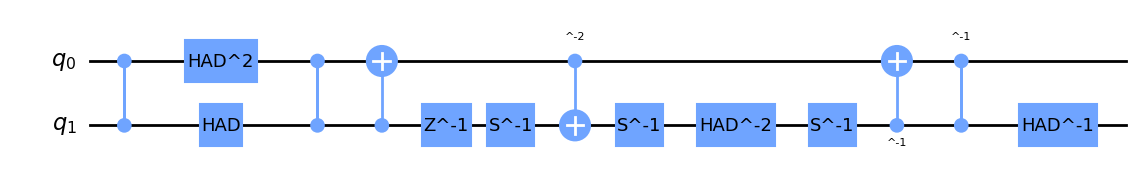

In [11]:
c.to_qiskit_rep().draw("mpl")

In [12]:
cs = simp.CliffordSimplifier(c)
# cs.verbose = True
# print(cs.dag)

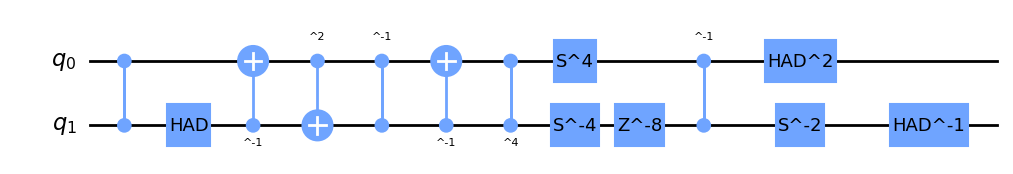

In [5]:
c = dizx.Circuit.from_qasm_file('../circuits/pauli_push1.qasm')
c.draw()

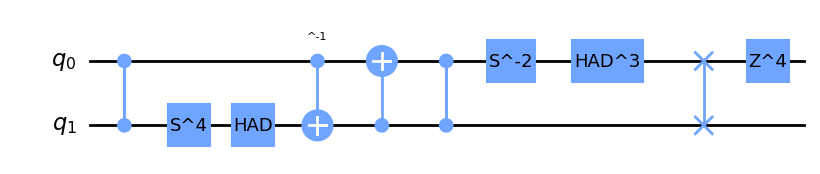

In [9]:
cs = simp.CliffordSimplifier(c)
cs.simple_optimize()
cs.push_CZ_past_CX()
cs.simple_optimize()
cs.transform_CX_to_SWAP()
cs.simple_optimize()
cs.transform_CX_to_SWAP()
cs.circuit.draw()

In [10]:
cs.circuit.to_symplectic_matrix()

Matrix([
[ 0,  0,  4,  1],
[-1,  1,  3,  1],
[ 2, -1, -4, -1],
[ 1,  0, -4, -1]])

In [11]:
c.to_symplectic_matrix()

Matrix([
[  1, 0,  0,  0],
[  2, 1,  1, -2],
[-10, 0, -1, -8],
[ -1, 0,  0, -1]])

In [5]:
cs.push_CZ_past_CX()

True

In [20]:
cs.push_S_past_CX()

True

In [ ]:
print(cs.dag)

In [ ]:
"hoi"

In [ ]:
cs.display_widget()

In [ ]:
c = dizx.Circuit(2,3)
c += HAD(0)
c += S(1)^2
c += CX(0,1)^-1
c += CZ(1,0)
c.to_qiskit_rep().draw("mpl")

In [ ]:
cs2 = simp.CliffordSimplifier(c)
cs2.push_S_gate()

In [ ]:
print(cs2.dag)
cs2.circuit.to_qiskit_rep().draw("mpl")

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
StepperWidget(cs).show()

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
for circ in cs.circuit_list:
    print(circ)

In [ ]:
cs.euler_decomp()

In [ ]:
cs.euler_decomp2()

In [ ]:
cs.dag